In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms
from pathlib import Path
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import timm

In [3]:
class DecoderHead(nn.Module):
    def __init__(self, input_dim=192):  # 192 = ViT tiny patch token dim
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(input_dim, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 14 -> 28
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 28 -> 56
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),  # 56 -> 224
            nn.Conv2d(32, 1, kernel_size=1)  # Output logits
        )

    def forward(self, x):
        return self.decoder(x)
def generate_mask(image_path, cam_path, threshold, transform, vit_model, decoder, use_finecam_only):
    img = Image.open(image_path).convert("RGB")
    fine_cam = np.load(cam_path)

    if use_finecam_only:
        mask = (fine_cam > threshold).astype(np.uint8)
        return mask, img, fine_cam, fine_cam

    img_tensor = transform(img).unsqueeze(0).to(device)
    fine_cam_tensor = torch.tensor(fine_cam, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    patch_tokens = get_patch_tokens_f(img_tensor, vit_model)
    preds = decoder(patch_tokens)

    loss_map = F.binary_cross_entropy_with_logits(preds, fine_cam_tensor, reduction='none')
    loss_map = loss_map.squeeze().detach().cpu().numpy()
    loss_map = (loss_map - loss_map.min()) / (loss_map.max() + 1e-6)

    mask = (loss_map > threshold).astype(np.uint8)
    return mask, img, fine_cam, loss_map
def get_patch_tokens_f(img_tensor, vit_model):
    with torch.no_grad():
        tokens = vit_model.patch_embed(img_tensor)
        cls_token = vit_model.cls_token.expand(img_tensor.size(0), -1, -1)
        tokens = torch.cat((cls_token, tokens), dim=1)
        tokens = vit_model.pos_drop(tokens + vit_model.pos_embed)
        for blk in vit_model.blocks:
            tokens = blk(tokens)
        patch_tokens = tokens[:, 1:].reshape(1, 14, 14, -1).permute(0, 3, 1, 2)
        return patch_tokens

def compute_iou(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    targets = (targets > 0.5).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = ((preds + targets) >= 1).float().sum(dim=(1, 2, 3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

/tmp/ipykernel_276807/2227191296.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load(vit_path, map_location=device))
/tmp/ipykernel_276

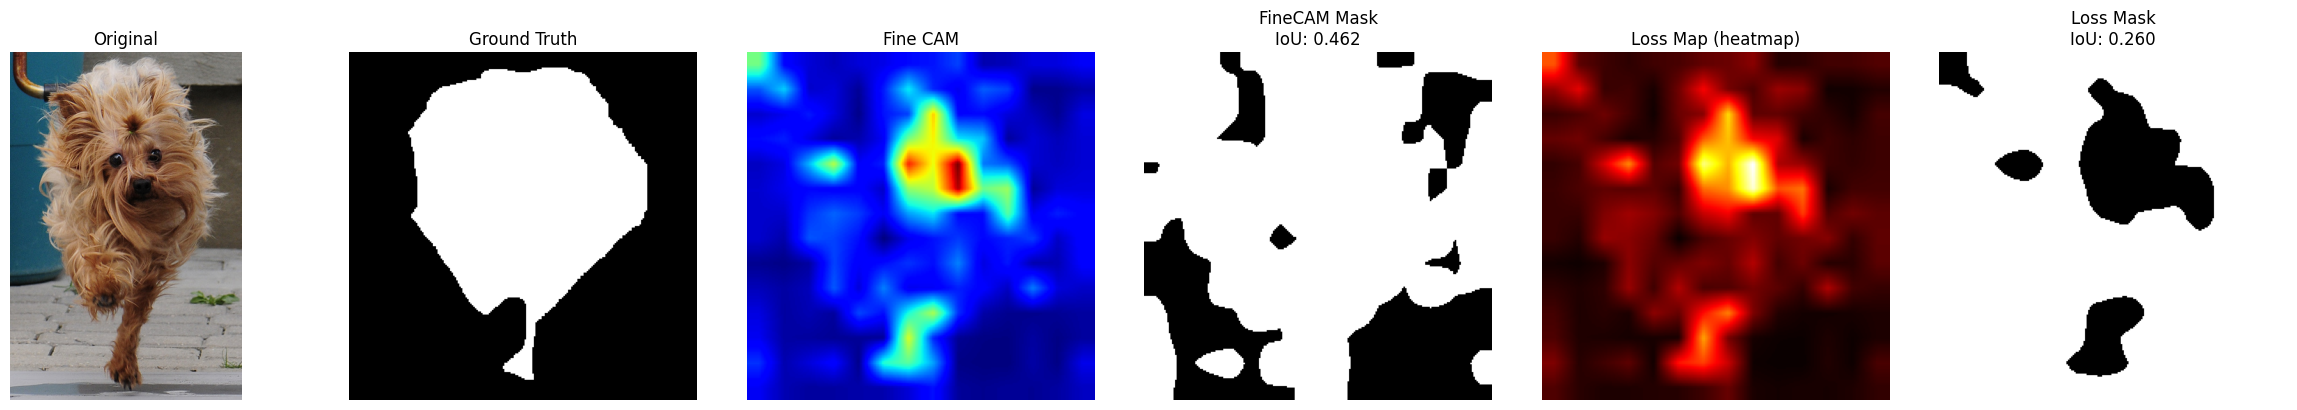

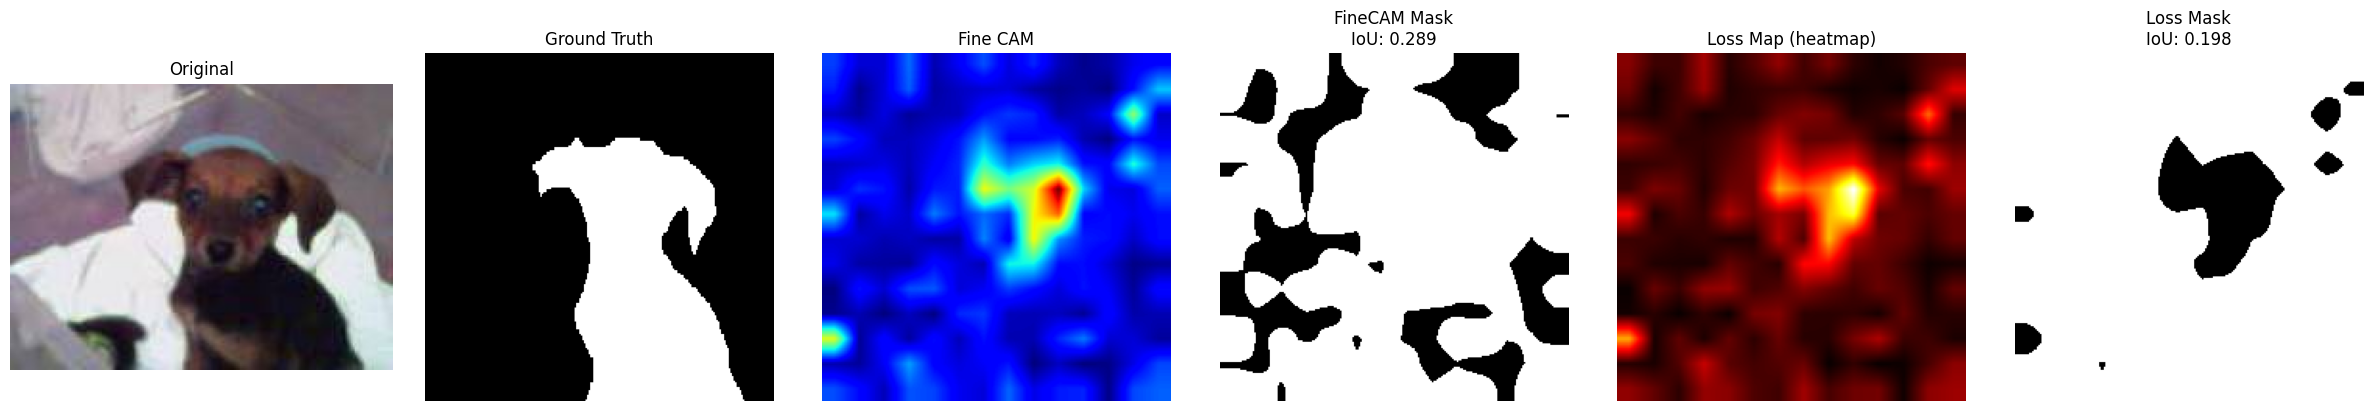

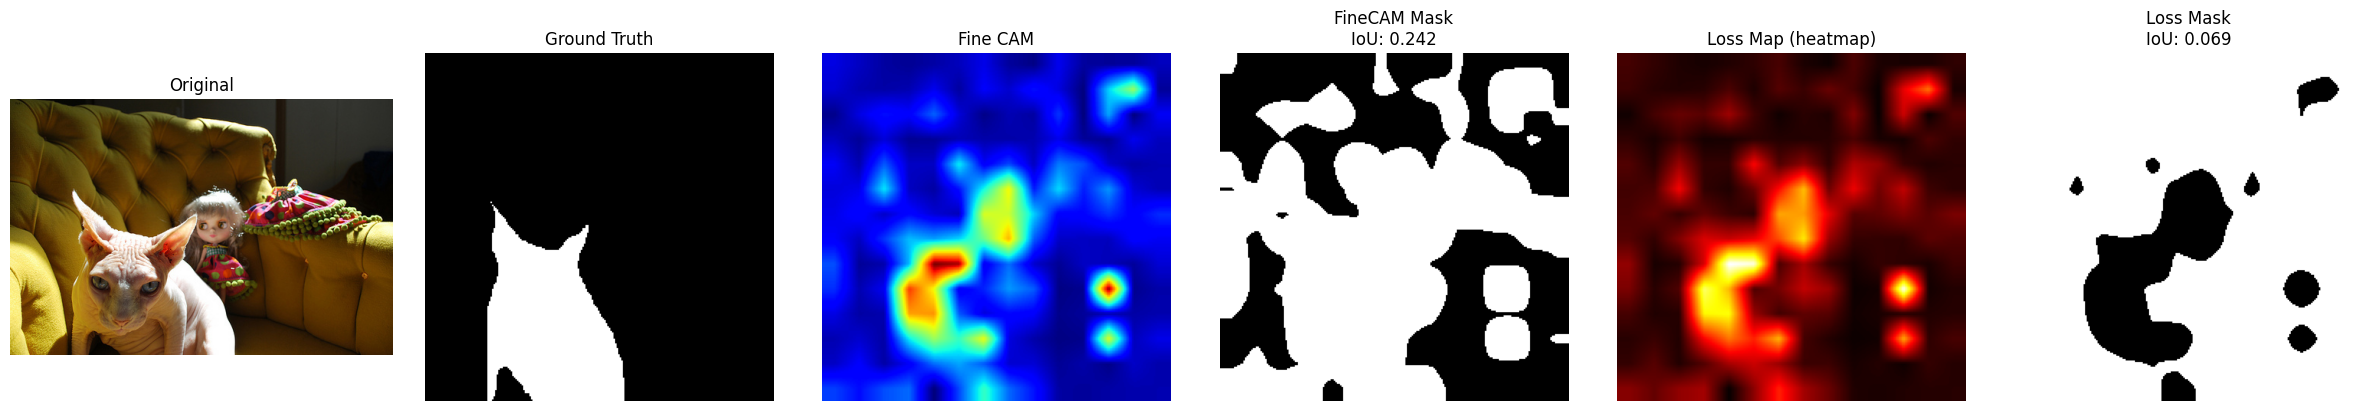

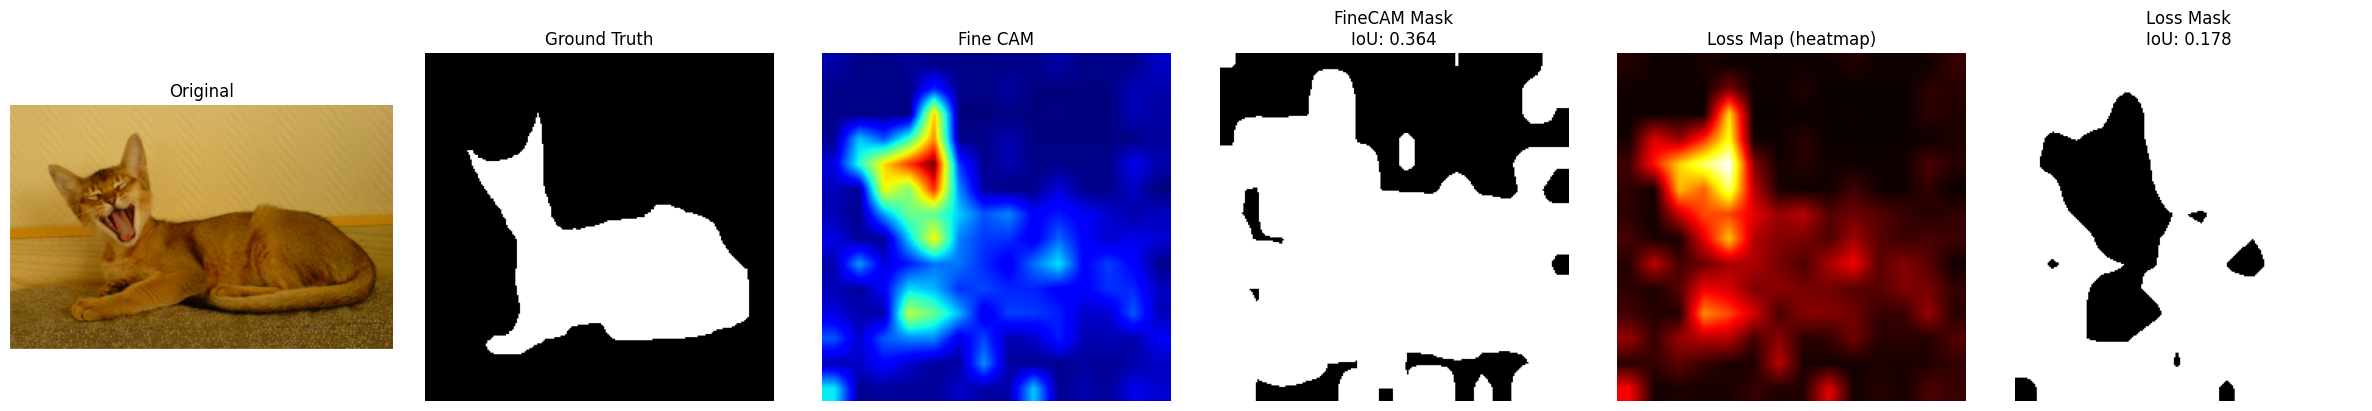

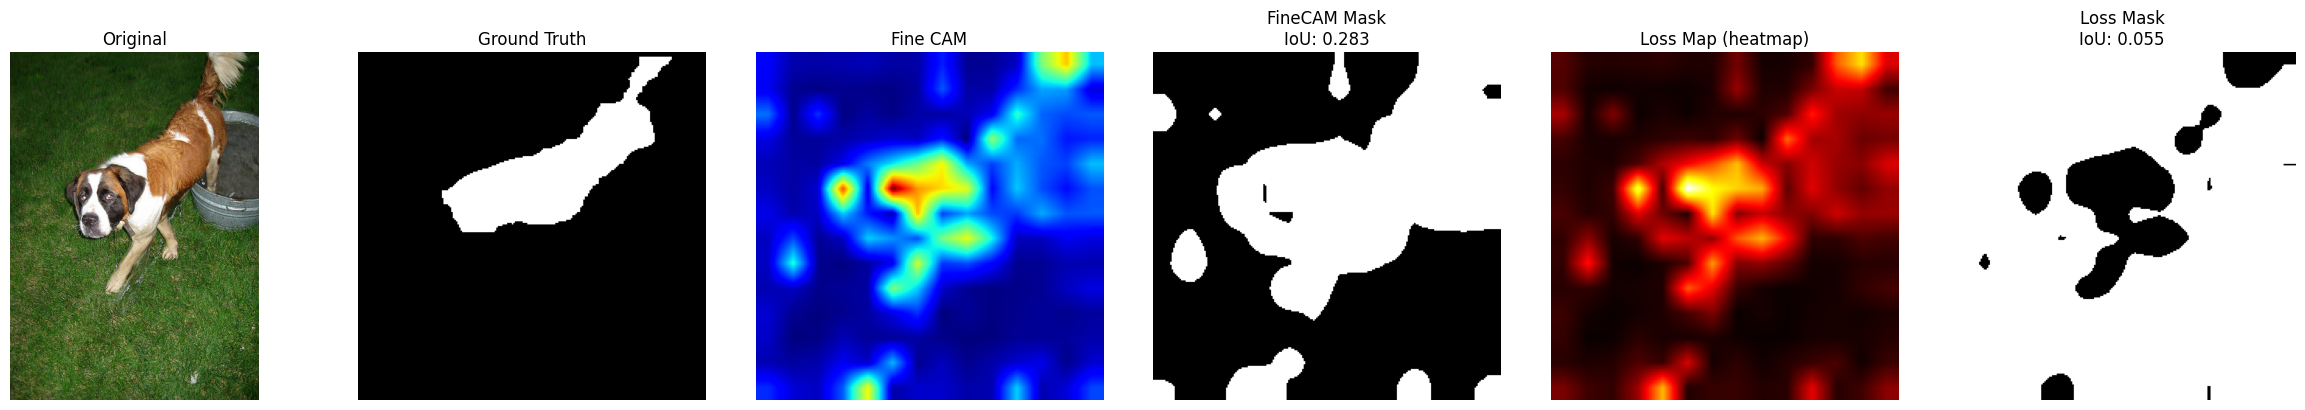

In [4]:
# --- Imports ---
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import mobilenet_v3_large
from pathlib import Path
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
import timm
from utils.utils import DecoderHead, generate_mask, compute_iou

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Paths ---
image_dir = Path("Data/Split/train/images")
gt_mask_dir = Path("Data/annotations/trimaps")
cam_dir = Path("FineCAMs")
models_dir = Path("Models")
vit_path = models_dir / "vit_pet_classifier_best.pth"
decoder_path = models_dir / "decoder_best.pth"

# --- Load ViT and Decoder ---
vit_model = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=37)
vit_model.load_state_dict(torch.load(vit_path, map_location=device))
vit_model.eval().to(device)

decoder = DecoderHead(input_dim=192).to(device)
decoder.load_state_dict(torch.load(decoder_path, map_location=device))
decoder.eval()

# --- Transforms ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

gt_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# --- Thresholds ---
threshold_fcam = 0.05
threshold_loss = 0.2
use_finecam_only = False  # toggled in `generate_mask` calls

# --- Sample random files ---
all_imgs = sorted([f for f in image_dir.iterdir() if f.suffix == ".jpg"])
samples = random.sample(all_imgs, 5)

# --- Visualization ---
for f in samples:
    cam_path = cam_dir / f.with_suffix(".npy").name
    gt_path = gt_mask_dir / f.with_suffix(".png").name

    if not cam_path.exists() or not gt_path.exists():
        print(f"⚠️ Missing CAM or GT for {f.name}, skipping...")
        continue

    # --- Generate masks ---
    mask_finecam, img, fine_cam, _ = generate_mask(
        f, cam_path, threshold_fcam, transform, vit_model, decoder, use_finecam_only=True)
    mask_loss, _, _, loss_map = generate_mask(
        f, cam_path, threshold_loss, transform, vit_model, decoder, use_finecam_only=False)

    # --- Ground truth ---
    gt = gt_transform(Image.open(gt_path))
    gt = (gt * 255).byte()
    gt = (gt == 1).float().squeeze().numpy()

    # --- IoU computation ---
    iou_finecam = compute_iou(
        torch.tensor(mask_finecam).unsqueeze(0).unsqueeze(0),
        torch.tensor(gt).unsqueeze(0).unsqueeze(0))
    iou_loss = compute_iou(
        torch.tensor(mask_loss).unsqueeze(0).unsqueeze(0),
        torch.tensor(gt).unsqueeze(0).unsqueeze(0))

    # --- Plot ---
    fig, axs = plt.subplots(1, 6, figsize=(24, 4))
    axs[0].imshow(img)
    axs[0].set_title("Original")

    axs[1].imshow(gt, cmap='gray')
    axs[1].set_title("Ground Truth")

    axs[2].imshow(fine_cam, cmap='jet')
    axs[2].set_title("Fine CAM")

    axs[3].imshow(mask_finecam, cmap='gray')
    axs[3].set_title(f"FineCAM Mask\nIoU: {iou_finecam:.3f}")

    axs[4].imshow(loss_map, cmap='hot')
    axs[4].set_title("Loss Map (heatmap)")

    axs[5].imshow(mask_loss, cmap='gray')
    axs[5].set_title(f"Loss Mask\nIoU: {iou_loss:.3f}")

    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


100%|██████████| 7099/7099 [03:59<00:00, 29.60it/s]


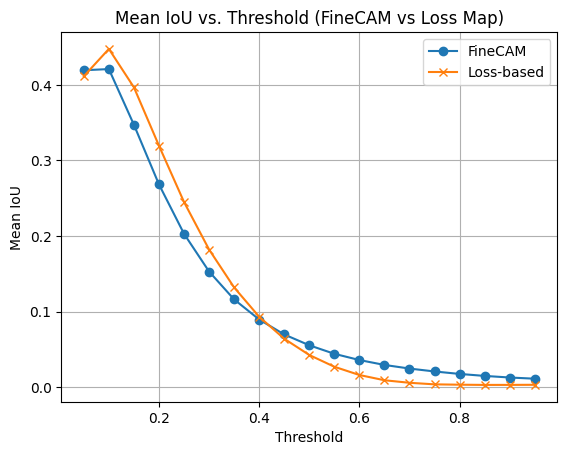

Best FineCAM IoU: 0.4208 @ threshold 0.1
Best Loss Mask IoU: 0.4475 @ threshold 0.1


In [5]:
# --- Thresholds to evaluate ---
thresholds = np.linspace(0.05, 0.95, 19)

# --- Initialize results ---
ious_finecam = {t: [] for t in thresholds}
ious_loss = {t: [] for t in thresholds}

# --- Sample all valid image paths ---
all_imgs = sorted([f for f in image_dir.iterdir() if f.suffix == ".jpg"])
valid_imgs = [f for f in all_imgs if (cam_dir / f.with_suffix(".npy").name).exists() and (gt_mask_dir / f.with_suffix(".png").name).exists()]

for f in tqdm(valid_imgs):
    cam_path = cam_dir / f.with_suffix(".npy").name
    gt_path = gt_mask_dir / f.with_suffix(".png").name

    gt = gt_transform(Image.open(gt_path))
    gt = (gt * 255).byte()
    gt = (gt == 1).float().squeeze().numpy()

    _, _, fine_cam, _ = generate_mask(f, cam_path, threshold=0.5, transform=transform, vit_model=vit_model, decoder=decoder, use_finecam_only=True)
    _, _, _, loss_map = generate_mask(f, cam_path, threshold=0.5, transform=transform, vit_model=vit_model, decoder=decoder, use_finecam_only=False)

    for th in thresholds:
        # FineCAM
        mask_fcam = (fine_cam > th).astype(np.uint8)
        iou_fcam = compute_iou(torch.tensor(mask_fcam).unsqueeze(0).unsqueeze(0),
                            torch.tensor(gt).unsqueeze(0).unsqueeze(0))
        ious_finecam[th].append(iou_fcam)

        # Loss Map
        mask_loss = (loss_map > th).astype(np.uint8)
        iou_loss_val = compute_iou(torch.tensor(mask_loss).unsqueeze(0).unsqueeze(0),
                                torch.tensor(gt).unsqueeze(0).unsqueeze(0))
        ious_loss[th].append(iou_loss_val)

# --- Average IoUs ---
avg_ious_fcam = [np.mean(ious_finecam[t]) for t in thresholds]
avg_ious_loss = [np.mean(ious_loss[t]) for t in thresholds]

# --- Plot ---
plt.plot(thresholds, avg_ious_fcam, label='FineCAM', marker='o')
plt.plot(thresholds, avg_ious_loss, label='Loss-based', marker='x')
plt.xlabel("Threshold")
plt.ylabel("Mean IoU")
plt.title("Mean IoU vs. Threshold (FineCAM vs Loss Map)")
plt.grid(True)
plt.legend()
plt.show()

# --- Best thresholds ---
best_fcam_th = thresholds[np.argmax(avg_ious_fcam)]
best_loss_th = thresholds[np.argmax(avg_ious_loss)]
print(f"Best FineCAM IoU: {max(avg_ious_fcam):.4f} @ threshold {best_fcam_th}")
print(f"Best Loss Mask IoU: {max(avg_ious_loss):.4f} @ threshold {best_loss_th}")


In [5]:
# --- Paths ---
image_dir = Path("Data/Split/train/images")
gt_mask_dir = Path("Data/annotations/trimaps")
pred_mask_dir = Path("RefinedMasks")  # <- your saved loss-based masks

# --- Transform for GT ---
gt_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# --- IoU Computation ---
def compute_iou(pred, target):
    pred = (pred > 0.5).astype(np.uint8)
    target = (target > 0.5).astype(np.uint8)
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()
    return intersection / union if union != 0 else 0

# --- Evaluation ---
ious = []
for img_file in tqdm(sorted(image_dir.glob("*.jpg"))):
    name = img_file.stem
    pred_path = pred_mask_dir / f"{name}.png"
    gt_path = gt_mask_dir / f"{name}.png"

    if not pred_path.exists() or not gt_path.exists():
        continue

    pred_mask = np.array(Image.open(pred_path).resize((224, 224))) / 255.0
    gt_mask = gt_transform(Image.open(gt_path)).squeeze().numpy()
    gt_mask = (gt_mask * 255).astype(np.uint8)
    gt_mask = (gt_mask == 1).astype(np.uint8)

    iou = compute_iou(pred_mask, gt_mask)
    ious.append(iou)

# --- Results ---
mean_iou = np.mean(ious)
print(f"\n✅ Mean IoU of saved masks (RefinedMasks_Loss025): {mean_iou:.4f}")

100%|██████████| 5912/5912 [00:07<00:00, 835.51it/s]


✅ Mean IoU of saved masks (RefinedMasks_Loss025): 0.1389


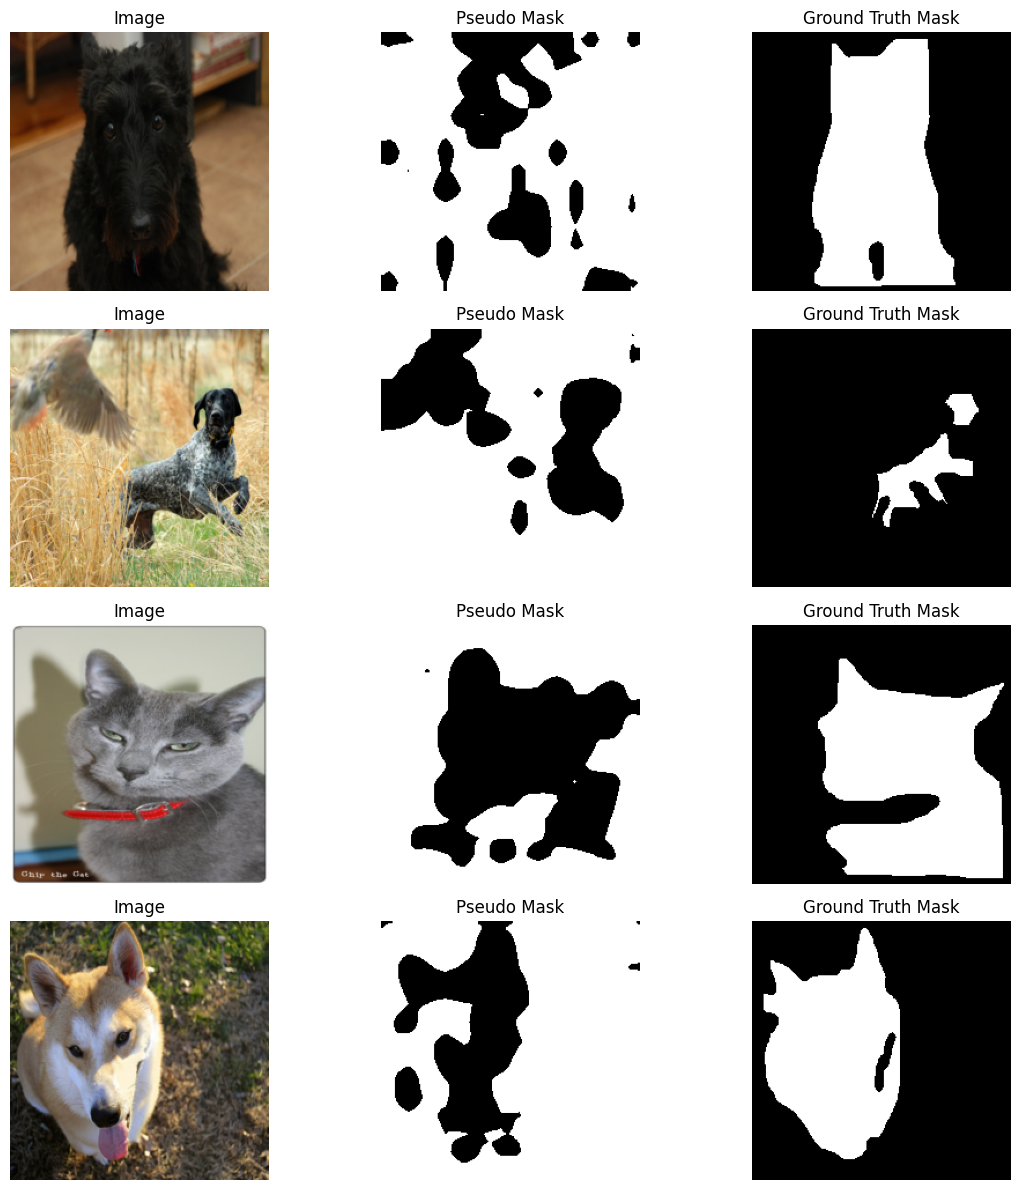

In [6]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from pathlib import Path
# from utils.utils import PetSegmentationDataset
from torchvision.datasets import VisionDataset

class PetSegmentationDataset(VisionDataset):
    def __init__(self, image_dir, mask_dir, gt_mask_dir, transform=None, target_transform=None):
        super().__init__(image_dir)
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.gt_mask_dir = Path(gt_mask_dir)
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        gt_mask_name = img_name
        img = Image.open(self.image_dir / img_name).convert("RGB")
        mask = Image.open(self.mask_dir / img_name.replace(".jpg", ".png"))
        gt_mask = Image.open(self.gt_mask_dir / gt_mask_name.replace(".jpg", ".png"))

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)
            gt_mask = self.target_transform(gt_mask)

        # mask = (mask * 255).byte()
        mask = (mask == 1).float()

        gt_mask = gt_mask.squeeze(0) * 255  # Convert from 0–1 to 0–255
        gt_mask = (gt_mask==1).float().unsqueeze(0)  # Pet + boundary

        return img, mask, gt_mask


# --- Paths ---
image_dir = "Data/Split/train/images"
mask_dir = "RefinedMasks"
gt_mask_dir = "Data/annotations/trimaps"

# --- Transforms ---
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# --- Dataset and DataLoader ---
dataset = PetSegmentationDataset(image_dir, mask_dir, gt_mask_dir,
                                 transform=img_transform,
                                 target_transform=mask_transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# --- Visualize a single batch ---
batch = next(iter(loader))
imgs, pseudo_masks, gt_masks = batch

# Unnormalize images for visualization
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

# Prepare images
imgs = [unnormalize(img).permute(1, 2, 0).numpy() for img in imgs]
pseudo_masks = [mask.squeeze().numpy() for mask in pseudo_masks]
gt_masks = [mask.squeeze().numpy() for mask in gt_masks]

# Plot
fig, axs = plt.subplots(len(imgs), 3, figsize=(12, 3 * len(imgs)))
for i in range(len(imgs)):
    axs[i, 0].imshow(imgs[i])
    axs[i, 0].set_title("Image")
    axs[i, 1].imshow(pseudo_masks[i], cmap="gray")
    axs[i, 1].set_title("Pseudo Mask")
    axs[i, 2].imshow(gt_masks[i], cmap="gray")
    axs[i, 2].set_title("Ground Truth Mask")
    for j in range(3):
        axs[i, j].axis("off")
plt.tight_layout()
plt.show()


In [7]:
mask.unique()

NameError: name 'mask' is not defined

In [ ]:
import torchvision.models.segmentation as models
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.lraspp_mobilenet_v3_large(pretrained=False, num_classes=1)
model = model.to(device)

/home/jose_caceres/miniconda3/envs/comp0197-cw1-pt-gpu/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jose_caceres/miniconda3/envs/comp0197-cw1-pt-gpu/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /home/jose_caceres/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:14<00:00, 1.57MB/s]


In [ ]:
np.unique(pseudo_masks[0])

array([0., 1.], dtype=float32)